# COCO Project 2024

### ReadMe
TODO

Address the following points in a clear and concise manner:
- How the failure scenario has been modeled in the simulation. 
- What parameters are used to demonstrate the failure scenario. 
- How the proposed model-based controller is implemented. 
- What parameters need to be tuned for the model-based controller.
- How you tuned the parameters for the model-based controller and how you would recommend tuning them.
- How the proposed data-driven controller is implemented. 
- What parameters need to be tuned for the data-driven controller.
- How you tuned the parameters for the data-driven controller and how you would recommend tuning them. 
- If you include an extra slide, a clear explanation of the implementation considerations of your bonus AP controller.


## Project Description

You are a control expert, and you are asked to act as a consultant for InsulinCo, a company that provides [artificial pancreas](https://moodle-app2.let.ethz.ch/pluginfile.php/2009034/mod_resource/content/1/Diabetes_101.pdf) (AP) care to patients with diabetes. Their AP uses an insulin pump to inject insulin in response to glucose measurements and meal predictions. Currently, their AP uses a PID controller.

InsulinCo would like to know if an advanced control method can improve the performance of their AP. You are provided with this Jupyter notebook to develop controller prototypes and provide an answer for them.

InsulinCo is interested in a model-based AP controller, as well as a data-driven AP controller. They want to know if they should pursue a product direction that involves a model that they, perhaps, modify for each patient, or a product direction that relies only upon data from the patient.

To support the model-based approach, InsulinCo has provided a nonlinear model for a specific patient and the linearization of the model at a steady-state operating point. To support the data-driven approach, InsulinCo has provided the time series data for a single patient that they would like you to use for the data-driven controller. 

To test/validate the controllers you develop, InsulinCo has provided you with the [ReplayBG simulator](https://github.com/gcappon/py_replay_bg/tree/master), developed by the company ReplayBGCo, which simulates the nonlinear dynamics of a human glucose regulation mechanism. For the (first) model-based and data-driven controllers that you design, InsulinCo would like you to just use the ReplayBG simulator for testing, not generating additional data. 

InsulinCo is also curious about partnering with ReplayBGCo. To make this decision, they need to know if they could improve their AP controller if they had a full commercial license for the ReplayBG simulator. For bonus credit, use the ReplayBG simulator, or data from the simulator, to either improve upon one of the two AP controllers you proposed in a significant manner, or demonstrate a new controller which requires a simulator or more data.


## Provided to you

This notebook, which contains
- A wrapper of the ReplayBG simulator for you so that you do not need to go through the ReplayBG codebase;
- A nonlinear model of the glucose dynamics derived by their medical specialists;
- A linearization of the nonlinear model for a given patient at a standard operating point;
- The specifications for the PID controller ("handler") that InsulinCo currently uses.

In addition, the JupyterHub contains a time series data set with the input/output data of a “typical” patient.

You may choose to demonstrate the behavior of the controllers using figures and metrics, such as Time-in-range, Time-above-range, and Time-below-range. These are being produced using [Agata](https://github.com/gcappon/py_agata/), a toolbox made to analyze glucose data.


## Code Submission Requirements

Your submission will be verified (your code will be run) using this JupyterHub. You may develop your code using a different machine (e.g. your own, Google Colab, etc.), but it must run in this JupyterHub and should complete in a reasonable (approximately less than 10 minutes) amount of time. If more time is required (e.g. for the bonus), please provide a clear explanation why more computation time is required and a clear demonstration of the output (figures, etc.) that is produced when the code runs to completion.

## Necessary Imports

All the necessary imports should be given in the script below. If you need another import you may add it with a clear description of why you are using it. Large packages such as Deep Reinforcement packages are not allowed since we have not covered that material in this course.

In [1]:
################################### Necessary Imports ##########################################
# all the necessary imports
################################################################################################

# Module for generationg the metrics
from py_agata.py_agata import Agata
from py_agata.time_in_ranges import time_in_target
from py_agata.utils import glucose_time_vectors_to_dataframe

# Function to plot the results
from plot_results import plot_results

# Function to run the simulation
from replay_bg_wrapper import simulate
from py_replay_bg.model.t1d_model import T1DModel
from py_replay_bg.py_replay_bg import ReplayBG

# Python imports
import pandas as pd
import os
import numpy as np
from random import randint

# Convex optimization problems with Python
from cvxpy.reductions.solvers.defines import QP_SOLVERS
import cvxpy as cp

## ReplayBG Model

The ReplayBG simulation is defined by the following differential equations:

<div>
    <img src="model.png" width="1000"/>
</div>


### Outputs

The output is the blood glucose. This hypoglycemia limit of 70 (mg/dl) is a hard lower-limit for blood glucose, as dropping below 70 (mg/dl) is a significant health risk. In addition, if possible, blood glucose should be kept below 180 (mg/dl). This hyperglycemia limit is a "soft constraint" rather than a hard constraint---minor infractions are not critical, but it is better to keep blood glucose below 180 (mg/dl) if possible.


### Inputs

Two inputs affect glucose levels:
- $i(t)$: Exogenous/Basal insulin injections (units "U" of insulin). Controlled.
- $m(t)$: Carbohydrate intake/"meals" (g). Not controlled.

Thus, the input is two-dimensional: $\textbf{u} = \begin{bmatrix}i(t) & m(t) \end{bmatrix}^T$. In the literature, $i(t)$ is also refered to as I(t) or basal_insulin, and $m(t)$ is also refered to as $CHO(t)$.

While we cannot control the meals, we assume that the meal injections are known by the controller (hence, being an "input" rather than a disturbance). 

The meals are determined by the `data_cho.csv` file and are parsed by the get_discretized_meals() function, which multiplies the values in the data.csv file by 5 because each meal takes 5 minuntes. 

The controller determines the exogenous insulin injection in control time intervals that are specified by the user (e.g. 5 or 10 minutes). The control time interval is a design decision for you to make. 

### Insulin Limits

The maximum exogenous/basal insulin injection $i(t)$ is 0.04, and the minimum is 0.

### Default Meal Values

The default meal values, which InsulinCo is interested in with the initial (model-based and data-driven) control designs, are 35 g for breakfast and 45 g for lunch and dinner.

For the bonus, you might consider larger/different meals.

### State Variables
The state of the system is defined by the following variables:
- $G_p(t)$: Plasma glucose concentration (mg/dl);
- $X(t)$: Insulin action on glucose disposal and production ($min^{-1}$);
- $Q_{sto1}(t)$: Amount of insulin in the stomach in solid state (mg/kg);
- $Q_{sto2}(t)$: Amount of insulin in the stomach in liquid state (mg/kg);
- $Q_{gut}(t)$: Glucose concentration in the intestine (mg/kg);
- $I_{sc1}(t)$: Insulin in a non-monomeric state (mU/kg);
- $I_{sc2}(t)$: Insulin in a monomeric state (mU/kg);
- $I_p(t)$: Plasma insulin concentration (mU/I);
- $G(t)$: interstitial glucose concentration (mg/dl);

For following the ReplayBG practices, the state equation is set as: $x(t) = \begin{bmatrix} G_p(t) & X(t) & Q_{sto1}(t) & Q_{sto2}(t) & Q_{gut}(t) & I_{sc1}(t) & I_{sc2}(t)& I_p(t) & G(t) \end{bmatrix}^T$.

### System Equations
The Non-Linear Differential Equations which describe the behavior of the system are the following:

$\dot{G_p}(t) = -[SG + \rho(G)X(t)] \cdot G_p(t) + SG \cdot G_{b} + R_{\alpha}(t)/V_G$

$\dot{X}(t) = -p_2 \cdot [X(t) - SI \cdot (I_p(t) - I_pb)]$

$\dot{Q}_{sto1}(t) = -k_{empt} \cdot Q_{sto1}(t) + m(t)$

$\dot{Q}_{sto2}(t) = k_{empt} \cdot Q_{sto1}(t) - k_{empt} \cdot Q_{sto2}(t)$

$\dot{Q}_{gut}(t) = k_{empt} \cdot Q_{sto2}(t) - k_{abs} \cdot Q_{gut}(t)$

$\dot{I}_{sc1}(t) = -k_{d}\cdot I_{sc1}(t) + i(t-\beta / V_{I})$

$\dot{I}_{sc2}(t) = k_{d}\cdot I_{sc1}(t) - k_{\alpha2} \cdot I_{sc2}(t)$

$\dot{I}_{p}(t) = k_{\alpha2} \cdot I_{sc2}(t) - k_{e} \cdot I_{p}(t)$

$\dot{G}(t) = -\frac{1}{\alpha}(G(t) - G_p(t))$

where, $k_{d}, k_{\alpha2}, k_e, \beta, k_{empt}, k_{abs}, \alpha, p_2$ are parameters describing the rate of diffusion and absorption of insulin, $V_{I}$ is the volume of insulin distribution, $R_{\alpha}(t)$ is the rate of glucose appearance in plasma, $SG$ is the glucose effectiveness, $G_b$ is the basal glucose concentration in the plasma, $V_G$ is the volume of glucose distribution, $I_{pb}$ is the basal insulin concentration in the plasma, $SI$ is the insulin sensitivity, $\rho(G)$ is a function to better represent glucose dynamics in the hypoglycemic range. 

The $I$ variables and the associated equations describe the absorption dynamics of exogenous insulin infusion to the plasma, the $Q$ variables describe the glucose absorption due to meals, and the last 3 equations describe the glucose-insulin kinetics subsystem.  

### Linearized Equations

We linearized the nonlinear dynamics above around the steady state $x_{ss} = \begin{bmatrix}120.0 & 0.0016 & 0.0 & 0.0 & 0.0 & 1.5081 &10.2735 & 0.2827 & 120.0\end{bmatrix}$ using a discretization step of 1 minute.
The linearized dynamics model has the form

$$\textbf{x}_{k+1} = A \textbf{x}_{k} + B\textbf{u}_{k} + h.$$
 
- $A \in \mathbb{R}^{9\times9}$ is the dynamics matrix,
- $B \in \mathbb{R}^{9\times2}$ is the input matrix, and
- $h \in \mathbb{R}^{9\times1}$ is the offset constant produced by the linearization.

<font color='red'>NOTE</font>: There are three different time intervals: the time-discretization of the simulation (1 minute), the meal time interval (5 minutes), and the controller actuation time interval (up to you).


## ReplayBG Specifics

simulate() runs a sytem simulation. It takes the following inputs:
- basal_handler: the function/controller that returns the  basal insulin injection value
- basal_handler_params: dict() with parameters defined by the control designer that can be accessed during simulation by the handler
- data_given: a pandas dataframe that describes the meal intake. The example below shows how to create the dataframe by reading the meal csv file (the control designer may change the csv file or define multiple csv files/dataframes as needed)
- meal_input_modulation_factor: constant that modules the impact of a meal (the default value should be used)

T1DModel: The T1DModel class is a part of ReplayBG's simulator and describes the glucose dynamics. It takes the following inputs:
- data: pandas dataframe which contains the preliminary meal data ("data" is not very relevant as it is overwritten with data_given when simulate() is called)
- bw: the body weight of the patient (the default value should be used)
- yts: The continuous glucose measurement (cgm) sample time (the default value should be used)
- glucose_model: the model equation to be used as measured glucose ('IG' should be used)
- is_single_meal: a flag indicating if the model will be used as single meal or multi meal (the default value (False) should be used)
- exercise: a boolean indicating if the model includes exercise (the default value (False) should be used)

The initial control design should not need most of the inputs, as InsulinCo is primarily interested in performance on the basic/default case. For the bonus, you could consider changing some of the inputs. Keep in mind, InsulinCo is primarily interested in new control methods rather than exhaustive studies, so any parameter changes should be used/changed to demonstrate the value of a given controller, not for the sake of an exhaustive study.

Below are some additional functions from InsulinCo intended to make the ReplayBG simulator easier to use.

get_linearization(): InsulinCO has provided this function to you to help design your controllers. It linearizes the dynamics around a given operating point but does *not* take into account the basal insulin injection delay. This means that for a given time index $t$ and a delay $\tau$, the basal insulin injection value returned by the controller will only be seen by the system at the time step $t+\tau$. This also means that for the same $t$, the control actions at the time steps between $t$ and $t+\tau-1$ are already defined and cannot be changed. 

<font color='red'>NOTE</font>: The ReplayBG simulator has a delay that is not included in the linearization. This delay must be factored in separately from the linearizaed dynamics described by the matrix $A$.

get_discretized_meals(): InsulinCo has provided this function to you to help interface between the ReplayBG simulator and the csv (that you may edit) that defines the meals. get_discretized_meals() is helpful because of how ReplayBG processes the meal data. Specifically, ReplayBG does some operations on the values written in the csv file to get the value of $m(t)$. Thus, to access this internal variable of ReplayBG, InsulinCo created this function which returns a vector with the all the $m[k]$ in a certain interval of time and according to a discretization time step. 

In [2]:
######################## additional functions for ReplayBG's T1DModel class  ###################
# Here define some additional functions for the T1DModel class that you may find useful.
################################################################################################

def get_discretized_meals(self, initial_time_step, duration, T):
    """
    Parameters
    ----------
    initial_time_step : initial time step of the intended interval that we want to get the meals from
    duration : duration of the interval that we want to get the meals from
    T : discretization step
    
    Returns
    -------
    meal : a vector with all the meals in the time interval given
    """
    meal = np.zeros((duration//T, ))
    for k in range((duration)):
        meal[k//T] += self.meal_ALL_delayed[initial_time_step+k]
    return meal
    

def get_linearization(self, T, x):
    """
    Provides the linearization parameters, given the discretization interval and the state at which the linearization is done.
    
    Parameters
    ----------
    T : discretization step
    x : linearization point
    
    Returns
    -------
    A, B, h : discretized linear state equations
    """

    x0 = x[0]
    x1 = x[1]

    mp = self.model_parameters

    k1_T = 1 / (1 + T*mp.kgri)
    k2_T = T*mp.kgri / (1 + T*mp.kempt)
    k3_T = 1 / (1 + T*mp.kempt)
    kb_T = 1 / (1 + T*mp.kabs_avg)
    ki1_T = 1 / (1 + T*mp.kd)
    ki2_T = 1 / (1 + T*mp.ka2)
    kie_T = 1 / (1 + T*mp.ke)

    x1_c_T = mp.p2 * mp.SI / mp.VI * T/(1+mp.p2*T)
    x4_c_T = T*mp.kempt * kb_T
    x6_c_T = T*mp.kd * ki2_T
    x7_c_T = T*mp.ka2 * kie_T

    df_dx0 = -mp.SG - x1 * (1 + mp.r1)
    df_dx1 = -x0 * (1 + mp.r1)
    df_dx4 = (mp.f * mp.kabs_avg) / mp.VG
    dx0_dt = -mp.SG*x0 -x0*x1*(1 + mp.r1) + mp.SG*mp.Gb
    div = (1-T*df_dx0)

    #                      x0               x1            x2      x3         x4        x5           x6            x7         x8
    self.Alinear[:] =  [ [1/div         , T*df_dx1/div , 0   , 0     , T*df_dx4/div, 0     , 0             , 0           , 0             ],
                         [0             , 1/(1+mp.p2*T), 0   , 0     , 0           , 0     , x1_c_T*x7_c_T , x1_c_T*kie_T, 0             ],
                         [0             , 0            , k1_T, 0     , 0           , 0     , 0             , 0           , 0             ],
                         [0             , 0            , k2_T, k3_T  , 0           , 0     , 0             , 0           , 0             ],
                         [0             , 0            , 0   , x4_c_T, kb_T        , 0     , 0             , 0           , 0             ],
                         [0             , 0            , 0   , 0     , 0           , ki1_T , 0             , 0           , 0             ],
                         [0             , 0            , 0   , 0     , 0           , x6_c_T, ki2_T         , 0           , 0             ],
                         [0             , 0            , 0   , 0     , 0           , 0     , x7_c_T        , kie_T       , 0             ], 
                         [T/(T+mp.alpha), 0            , 0   , 0     , 0           , 0     , 0             , 0           , mp.alpha/(T+mp.alpha)]]

    self.Blinear[:] = [0, 0, 0, 0, 0, T/(1+T*mp.kd)*mp.to_mgkg, 0, 0, 0]
    self.Mlinear[:] = [0, 0, k1_T, 0, 0, 0, 0, 0, 0]
    self.hlinear[:] = [ T*(dx0_dt - x0*df_dx0 - x1*df_dx1)/div, 0, 0, 0, 0, 0, 0, 0, 0]

    return self.Alinear, np.vstack((self.Blinear, self.Mlinear)).T, self.hlinear

In [3]:
##################################### Linearization example  ###################################
# A demonstration of T1DModel and get_linearization()
################################################################################################

# State Definition
x0 = np.array([120.0, 0.0016, 0.0, 0.0, 0.0, 1.5081, 10.2735, 0.2827, 120.0])
tau = 8 # min of delay for controler to act

#Some parameters of the patient (everything is set in the simulation for your controllers. These are only examples)
bw = 62.0
is_single_meal = False
data = pd.read_csv(
        os.path.join(os.path.abspath(''), 'data', 'data_cho.csv'))
data.t = pd.to_datetime(data['t'], format='mixed')

t1d_model = T1DModel(data=data,
                     bw=bw,
                     yts=5,
                     glucose_model='IG',
                     is_single_meal=False,
                     exercise=False)

# To design the controller two function will be needed:
# - t1d_model.get_linearization
# - t1d_model.get_discretized_meals 

# Example of running the function for getting the system equations
A_, B_, h_ = t1d_model.get_linearization(1, x0)
print("A:\n", A_.round(3), "\n"*2, "B:\n", B_.round(3), "\n"*2, "h:\n", h_.round(3))
i = 0.0
m = 0.0

A:
 [[ 9.72000e-01 -2.84656e+02  0.00000e+00  0.00000e+00  7.00000e-03
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  9.88000e-01  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  8.47000e-01  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  1.53000e-01  8.47000e-01  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.78000e-01  9.88000e-01
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   9.75000e-01  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   2.60000e-02  9.86000e-01  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  1.20000e-02  8.87000e-01  0.00000e+00]
 [ 1.25000e-01  0.00

## Simulator Demonstration with a simple logic-based controller

To develop intuition, InsullinCo has provided a scenario with a basic basal insulin controller: if glucose is below 90 no insulin is delivered; if glucose is above 90, a default rate is delivered. 

The file `(data_cho.csv)` describes the meal consumption for the patient over the course of a day.

In [4]:
##################################### simple controller example  ###################################

def basal_insulin_controller_example(model, x0, tau, time_index, inputs_, xss, uss, dss):
    """
    Implements the default basal rate controller: "if G < 90 mg/dl, deliver basal = 0; otherwise, deliver basal = default_rate U/min".

    Parameters
    -------
    model: the T1DModel class describing the dynamics, provided by ReplayBG
    x0: the current state
    tau: delay of the system in min
    time_index: shows the current time step
    inputs_: a time series with the basal input that was/will be applied to the system
             (useful for implementing delay)
    xss, uss: the linearization point
    dss: Contains basal_handler_params and servers two functions:
         1) a dict that for the controller hyperparameters.
         2) memory for the next iteration (hence dss also being an output)
    
    Returns
    -------
    i: The basal insulin rate to administer at time[time_index+1].
    dss: [see above]
    """

    i = dss.basal_handler_params['default_rate']
    
    # Get future meals
    meal = model.get_discretized_meals(initial_time_step=time_index, duration=5, T=1)
    # meal is not used in this controller but can be relevant for the controller you will design

    # If G < 90...
    if x0[0] < 90:
        # ...set basal rate to 0
        i = 0

    return i, dss

In [5]:
##################################### Example of loading and modifying meal data  ###################################

# # Load the CSV File
# df = pd.read_csv('data/data_cho.csv')

# # Print the first lines of the File (otherwise you can also easily check it by manually opening the file in Jupyter lab)
# print("Patient Datasheet", "\n", df.head())

# # Modify the DataFrame
# # Suppose you want to change the value in row 1, column 'ColumnName' to 'NewValue'
# df.at[108, 'cho'] = 9

# # Save the Modified DataFrame
# df.to_csv('your_file.csv', index=False)

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\py_agata\variability\__init__.py:729: RuntimeWarning: Mean of empty slice
  mage_day_plus[d] = np.nanmean(excursions[excursions > 0])
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'variability': {'mean_glucose': 91.96744503945959, 'median_glucose': 99.3508829662095, 'std_glucose': 29.31474126593454, 'cv_glucose': 31.87512847981886, 'range_glucose': 91.08785421057581, 'iqr_glucose': 57.88307315705032, 'auc_glucose': 160023.3543686597, 'gmi': 5.509861285343874, 'cogi': 48.550125181071216, 'conga': 43.626348666351895, 'j_index': 14.709368715016334, 'mage_plus_index': 34.52465751299798, 'mage_minus_index': 67.75788242572915, 'mage_index': 51.14126996936356, 'ef_index': 1.5, 'modd': 61.142443827316725, 'sddm_index': 27.927723760455923, 'sdw_index': 22.971246183413754, 'std_glucose_roc': 0.0823336149927993, 'cvga': 3667.7874096184123}, 'time_in_ranges': {'time_in_target': 70.86206896551724, 'time_in_tight_target': 70.86206896551724, 'time_in_hypoglycemia': 29.137931034482758, 'time_in_l1_hypoglycemia': 10.344827586206897, 'time_in_l2_hypoglycemia': 18.79310344827586, 'time_in_hyperglycemia': 0.0, 'time_in_l1_hyperglycemia': 0.0, 'time_in_l2_hyperglycemia': 0.0}, 'ris

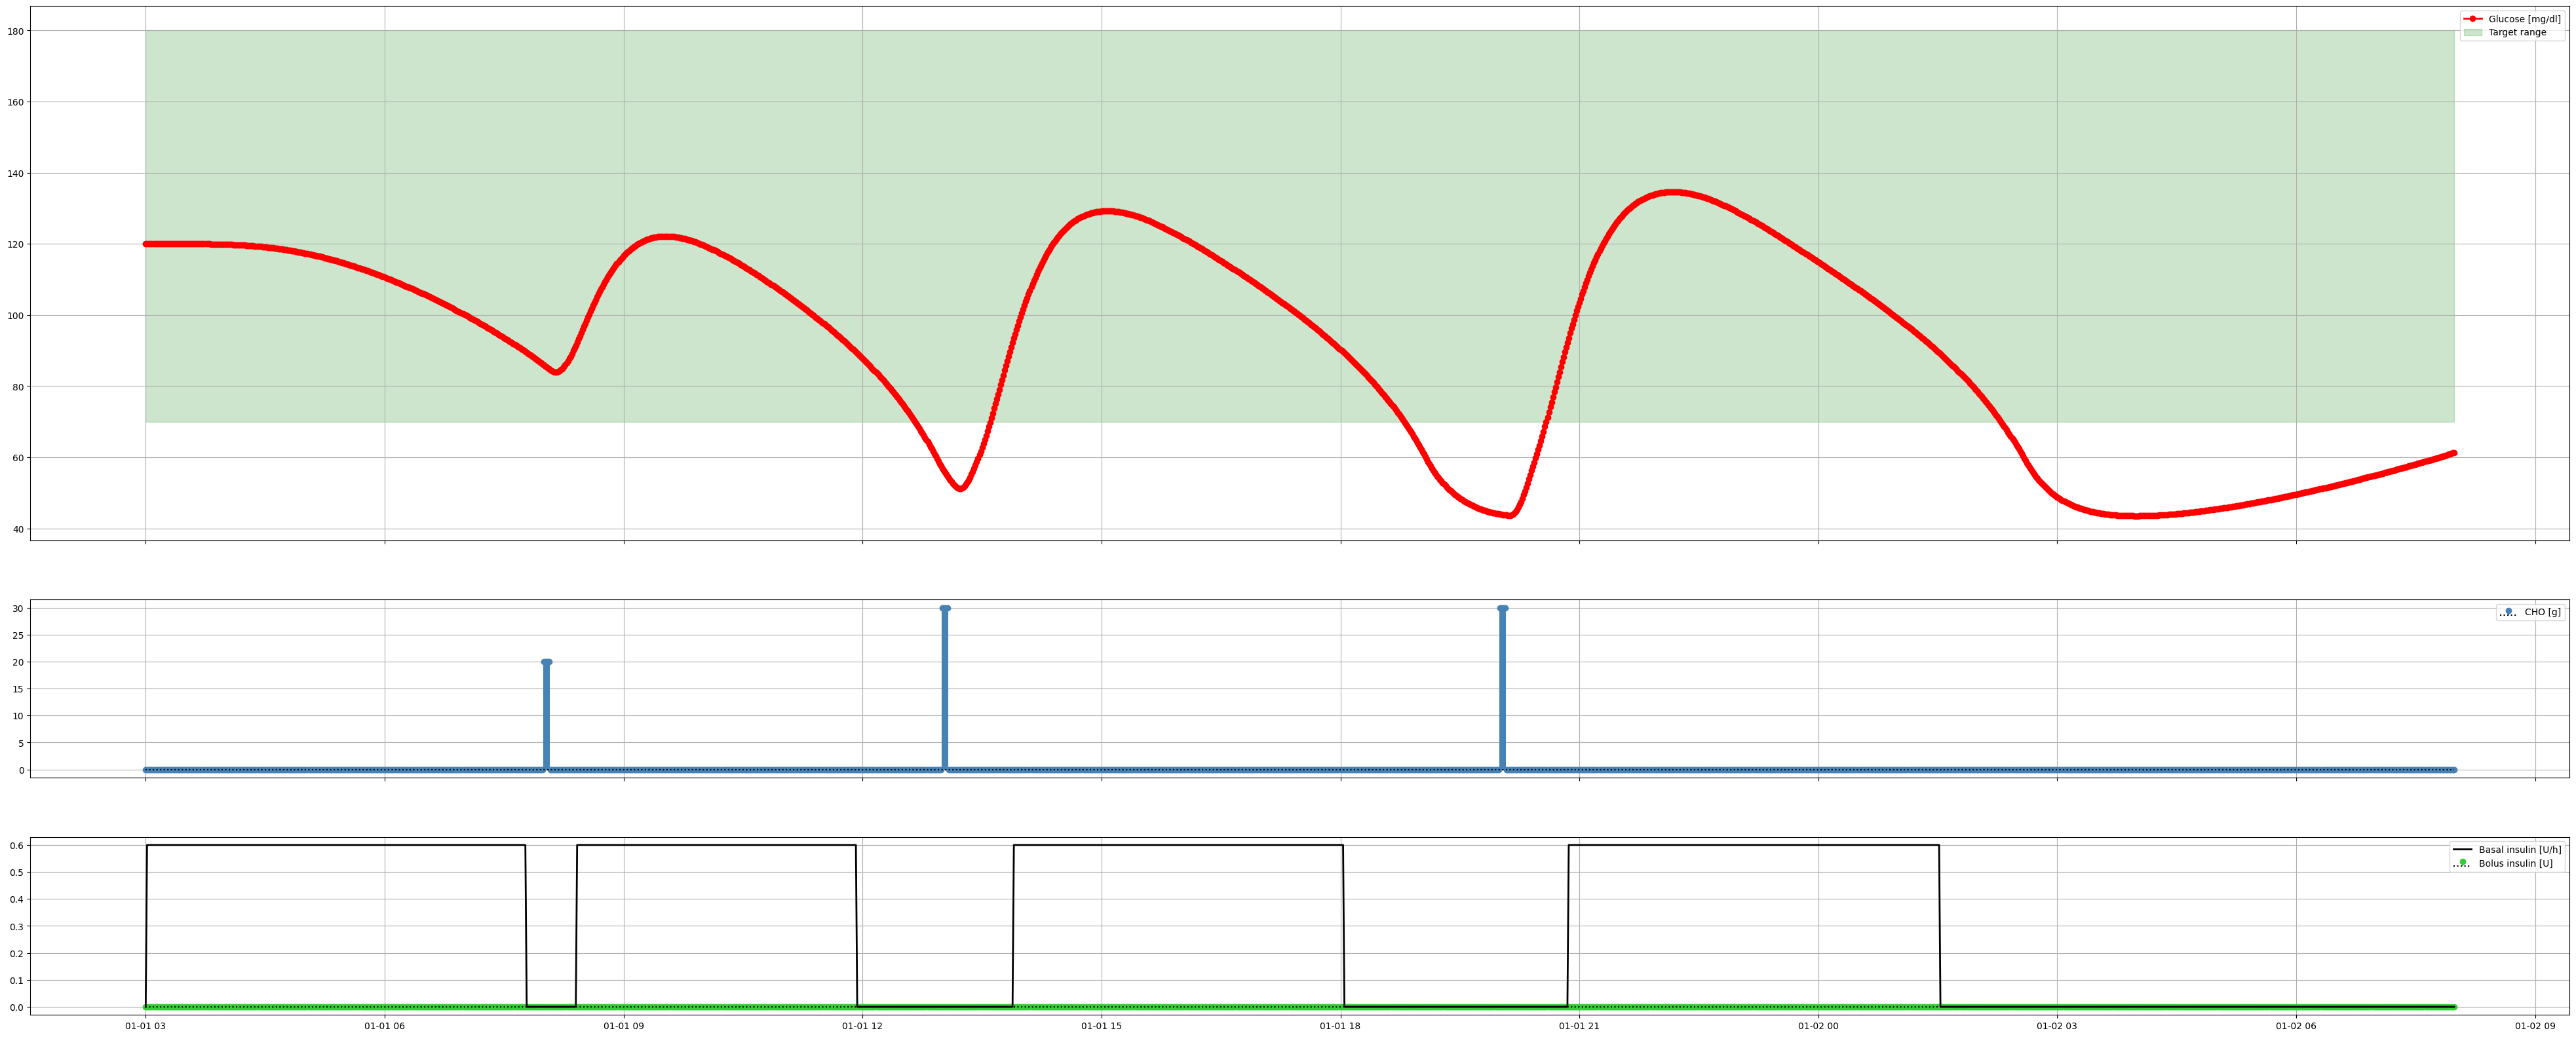

In [6]:
##################################### Example of displaying simulation results  ###################################

# You can create a dict() that will be accessible during simulation by your handler
basal_handler_params = dict()
basal_handler_params['default_rate'] = 0.01

data_given = pd.read_csv(os.path.join(os.path.abspath(''), 'data', 'data_cho.csv'))

glucose, i, insulin_bolus, m, time = simulate(basal_handler=basal_insulin_controller_example,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)

# After simulation, you can evaluate glucose trace with AGATA.
# First, generate a dataframe that is compatible with AGATA https://github.com/gcappon/py_agata/
data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

# Then glucose trace can be analyzed with Agata().analyze_glucose_profile() 
agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

# ... or, if you need just 1 metric, you can use a metric such as time_in_target
TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

#Finally, a function to plot the simulation traces
plot_results(glucose=glucose, insulin_bolus=insulin_bolus, i=i, m=m, time=time)

## PID Controller

The following code initializes Insulin Co's PID controller. 

In [7]:
class PIDController:
    def __init__(self, Ki, Kd, Kp):
        self.Ki = Ki
        self.Kd = Kd
        self.Kp = Kp
        self.integral = 0
        self.prev_error = 0
        self.check = True
    
    def compute_pid(self, model, x0, tau, time_index, inputs_, xss, uss, dss):
        # Error calculation from the desired setpoint
        error = x0[8] - xss[8]
        ########################################################
        # meal = model.get_discretized_meals(initial_time_step=time_index, duration=5, T=1)

        # if self.check:
        #     print("----------")
            
        #     # print(len(inputs_))
        #     # print(meal)
        #     print("----------")
        #     self.check = False
        # print("----------")
        # print(meal)
        # print(time_index + tau + 2)
        # print("----------")
        #######################################################
        # Integral, Derivative, and Proportional terms of PID
        self.integral += error * 1
        derivative = (error - self.prev_error) / 1
        self.prev_error = error
        
        # Calculate PID control output
        control_output = self.Ki * self.integral + self.Kd * derivative + self.Kp * error + uss
        
        # Ensure control output is within valid limits (e.g., non-negative)
        control_output = max(0, control_output)
        
        return control_output, dss

    def restart(self):
        self.integral = 0
        self.prev_error = 0

## Task 1: Current state 

Below demonstrates how InsulinCo's PID controller performs in a standard operating condition.

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'variability': {'mean_glucose': 164.53877850456064, 'median_glucose': 120.3851321035215, 'std_glucose': 52.73910247135605, 'cv_glucose': 32.052688703954516, 'range_glucose': 133.3693542291635, 'iqr_glucose': 99.00102557286135, 'auc_glucose': 65815.51140182426, 'gmi': 7.2457675818290905, 'cogi': 75.09393065744987, 'conga': 25.9094456942505, 'j_index': 47.20967756138461, 'mage_plus_index': 133.3693542291635, 'mage_minus_index': 86.9552082899807, 'mage_index': 110.1622812595721, 'ef_index': 2.0, 'modd': nan, 'sddm_index': nan, 'sdw_index': 52.73910247135605, 'std_glucose_roc': 0.1876627790415522, 'cvga': 1092.687966455989}, 'time_in_ranges': {'time_in_target': 61.75, 'time_in_tight_target': 55.0, 'time_in_hypoglycemia': 0.0, 'time_in_l1_hypoglycemia': 0.0, 'time_in_l2_hypoglycemia': 0.0, 'time_in_hyperglycemia': 38.25, 'time_in_l1_hyperglycemia': 30.5, 'time_in_l2_hyperglycemia': 7.75}, 'risk': {'adrr': 23.199940260634257, 'lbgi': 0.0, 'hbgi': 7.164100762511245, 'bgri': 7.164100762511245

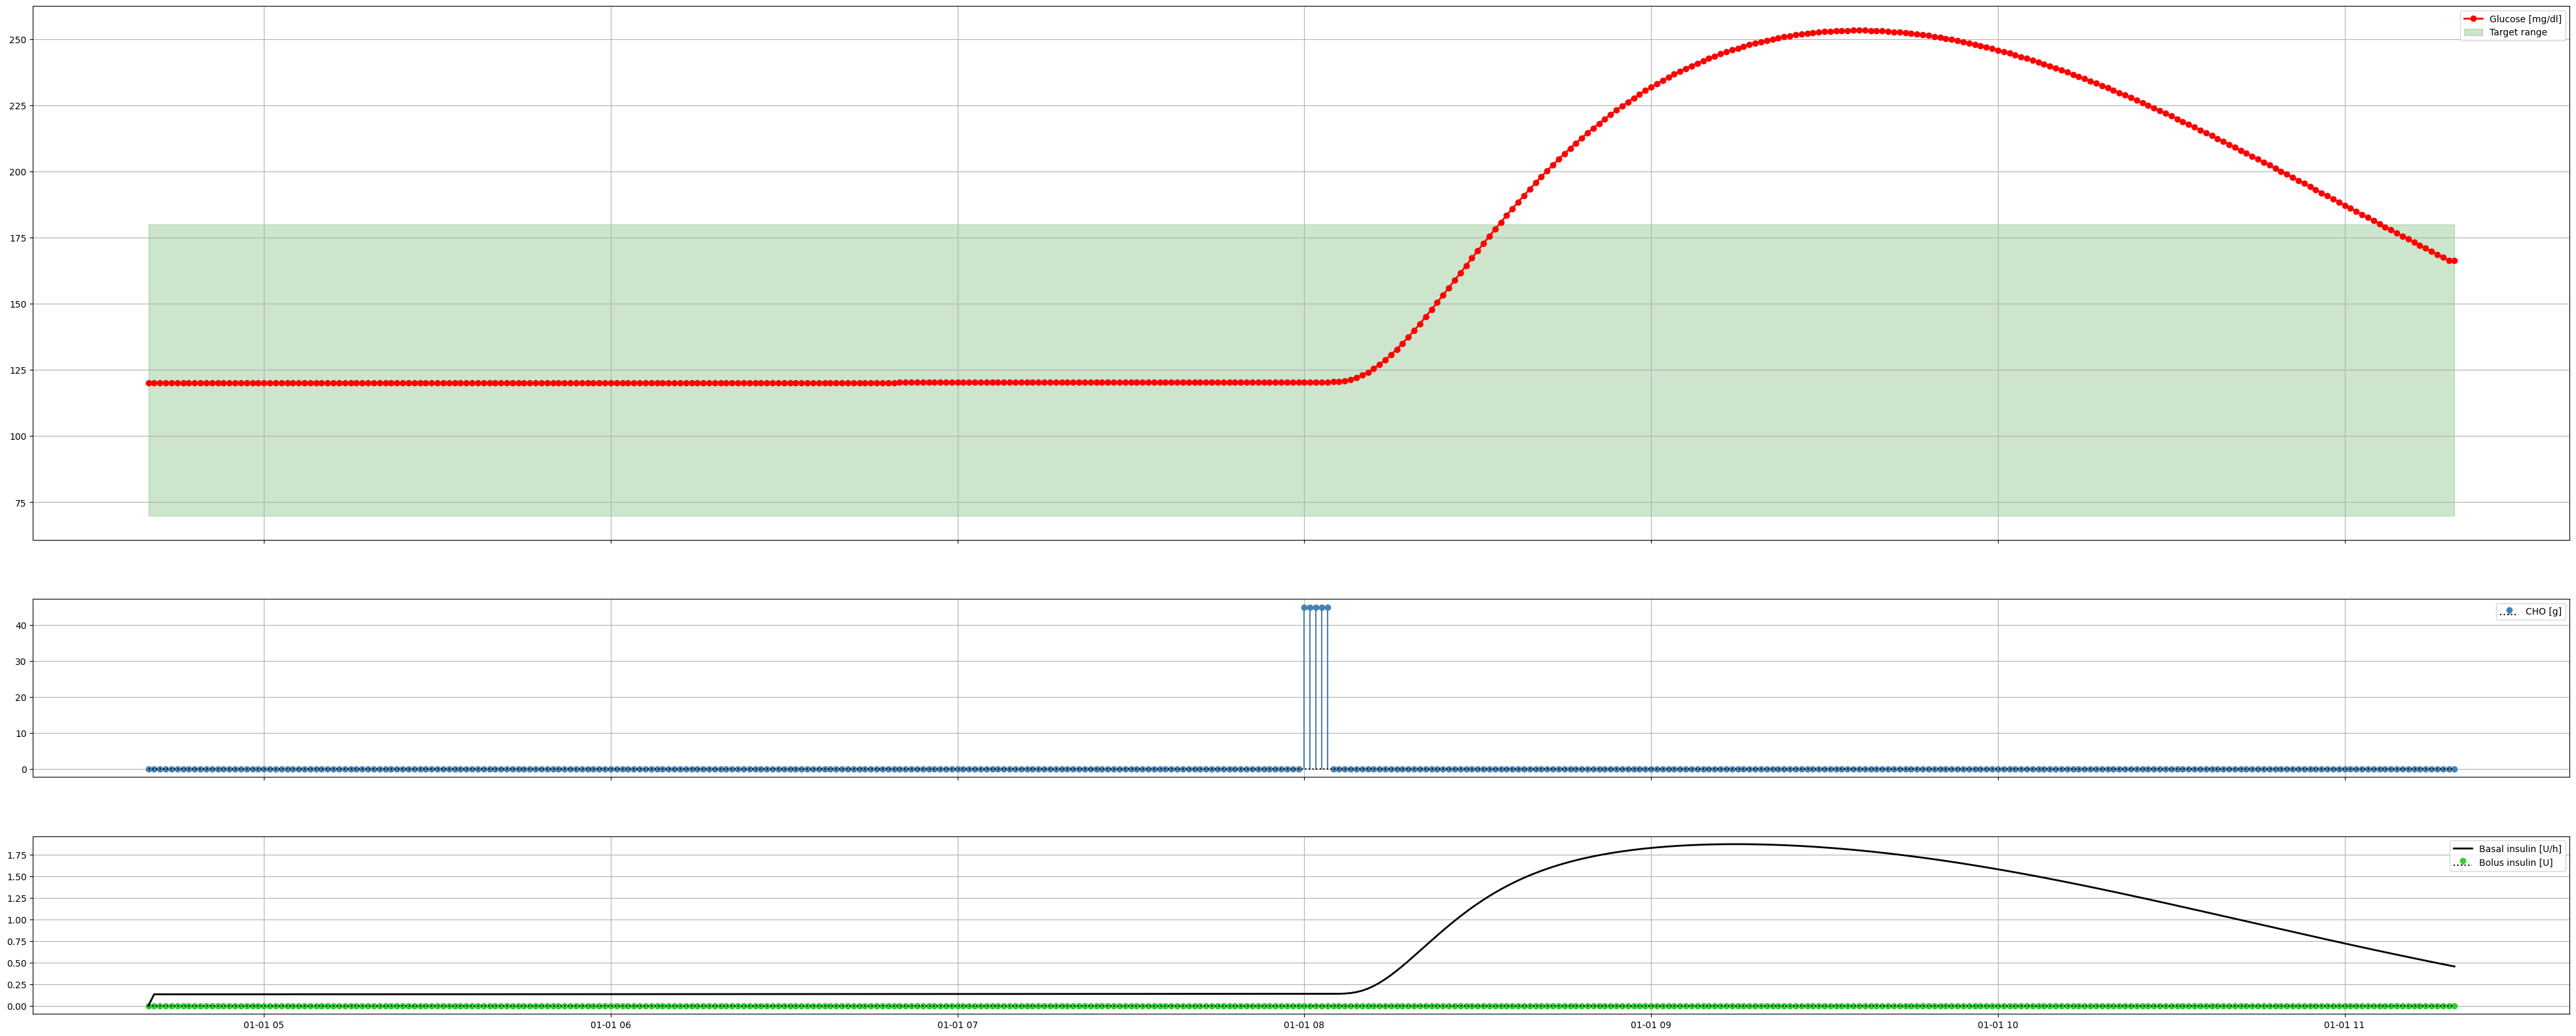

In [8]:
##################################### Demonstration of InsulinCo's PID control  ###################################

basal_handler_params = dict()
basal_handler_params['default_rate'] = 0.01

# Get test data
# data_given = pd.read_csv('data/data_cho.csv')
data_given = pd.read_csv('data/easy_test.csv')
# data_given = pd.read_csv('data/task01_failure_mode.csv')

# Instatiating PID Controller
pid_controller = PIDController(Ki=0.0, Kd=0.005, Kp=0.0002)

# Running the simulation
glucose, i, insulin_bolus, m, time = simulate(basal_handler=pid_controller.compute_pid,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)

data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)

## Task 2: Failure Mode

Demonstrate a compelling failure scenario in which InsulinCo's PID controller fails to successfully regulate insulin to motivate a better controller.

As "the default meal values, which InsulinCo is interested in with the initial (model-based and data-driven) control designs, are 35 g for breakfast and 45 g for lunch and dinner", the performance of the PID controller is evaluated with these values.

In [9]:
##################################### Modify csv data  ###################################
# Load the CSV File
df = pd.read_csv('data/data_cho.csv')

# Default meal values
discretization_time_meal = 5 #discretization time for meals
m_B = 35 #g of carbohydrates for breakfast
m_L = 45 #g of carbohydrates for lunch
m_D = 45 #g of carbohydrates for dinner

# Modify the DataFrame
df.loc[df['cho_label'] == 'B', 'cho'] = m_B / discretization_time_meal
df.loc[df['cho_label'] == 'L', 'cho'] = m_L / discretization_time_meal
df.loc[df['cho_label'] == 'D', 'cho'] = m_D / discretization_time_meal

# Save the Modified DataFrame
df.to_csv(os.path.join(os.path.abspath(''), 'data', 'task01_failure_mode.csv'))

In [10]:
##################################### Modify csv data  ###################################
# Load the CSV File
df = pd.read_csv('data/data_cho.csv')

# Default meal values
discretization_time_meal = 5 #discretization time for meals
m_B = 45 #g of carbohydrates for breakfast
m_L = 10 #g of carbohydrates for lunch
m_D = 10 #g of carbohydrates for dinner

# Modify the DataFrame
df.loc[df['cho_label'] == 'B', 'cho'] = m_B / discretization_time_meal
df.loc[df['cho_label'] == 'L', 'cho'] = m_L / discretization_time_meal
df.loc[df['cho_label'] == 'D', 'cho'] = m_D / discretization_time_meal

# Cut df
df = df[20:100]

# Save the Modified DataFrame
df.to_csv(os.path.join(os.path.abspath(''), 'data', 'easy_test.csv'))

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'variability': {'mean_glucose': 120.21162057894125, 'median_glucose': 120.22713615766176, 'std_glucose': 0.14092040005409412, 'cv_glucose': 0.11722693644376395, 'range_glucose': 0.4010763828022448, 'iqr_glucose': 0.2771768069984404, 'auc_glucose': 48084.6482315765, 'gmi': 6.185461964248274, 'cogi': 100.0, 'conga': 0.22492192836729752, 'j_index': 14.484734120100756, 'mage_plus_index': 0.3964897097832676, 'mage_minus_index': 0.4010763828022448, 'mage_index': 0.3987830462927562, 'ef_index': 0.0, 'modd': nan, 'sddm_index': nan, 'sdw_index': 0.14092040005409412, 'std_glucose_roc': 0.00045800790982163277, 'cvga': 13.375811869289322}, 'time_in_ranges': {'time_in_target': 100.0, 'time_in_tight_target': 100.0, 'time_in_hypoglycemia': 0.0, 'time_in_l1_hypoglycemia': 0.0, 'time_in_l2_hypoglycemia': 0.0, 'time_in_hyperglycemia': 0.0, 'time_in_l1_hyperglycemia': 0.0, 'time_in_l2_hyperglycemia': 0.0}, 'risk': {'adrr': 0.1592876921328555, 'lbgi': 0.0, 'hbgi': 0.15217729944319394, 'bgri': 0.152177299

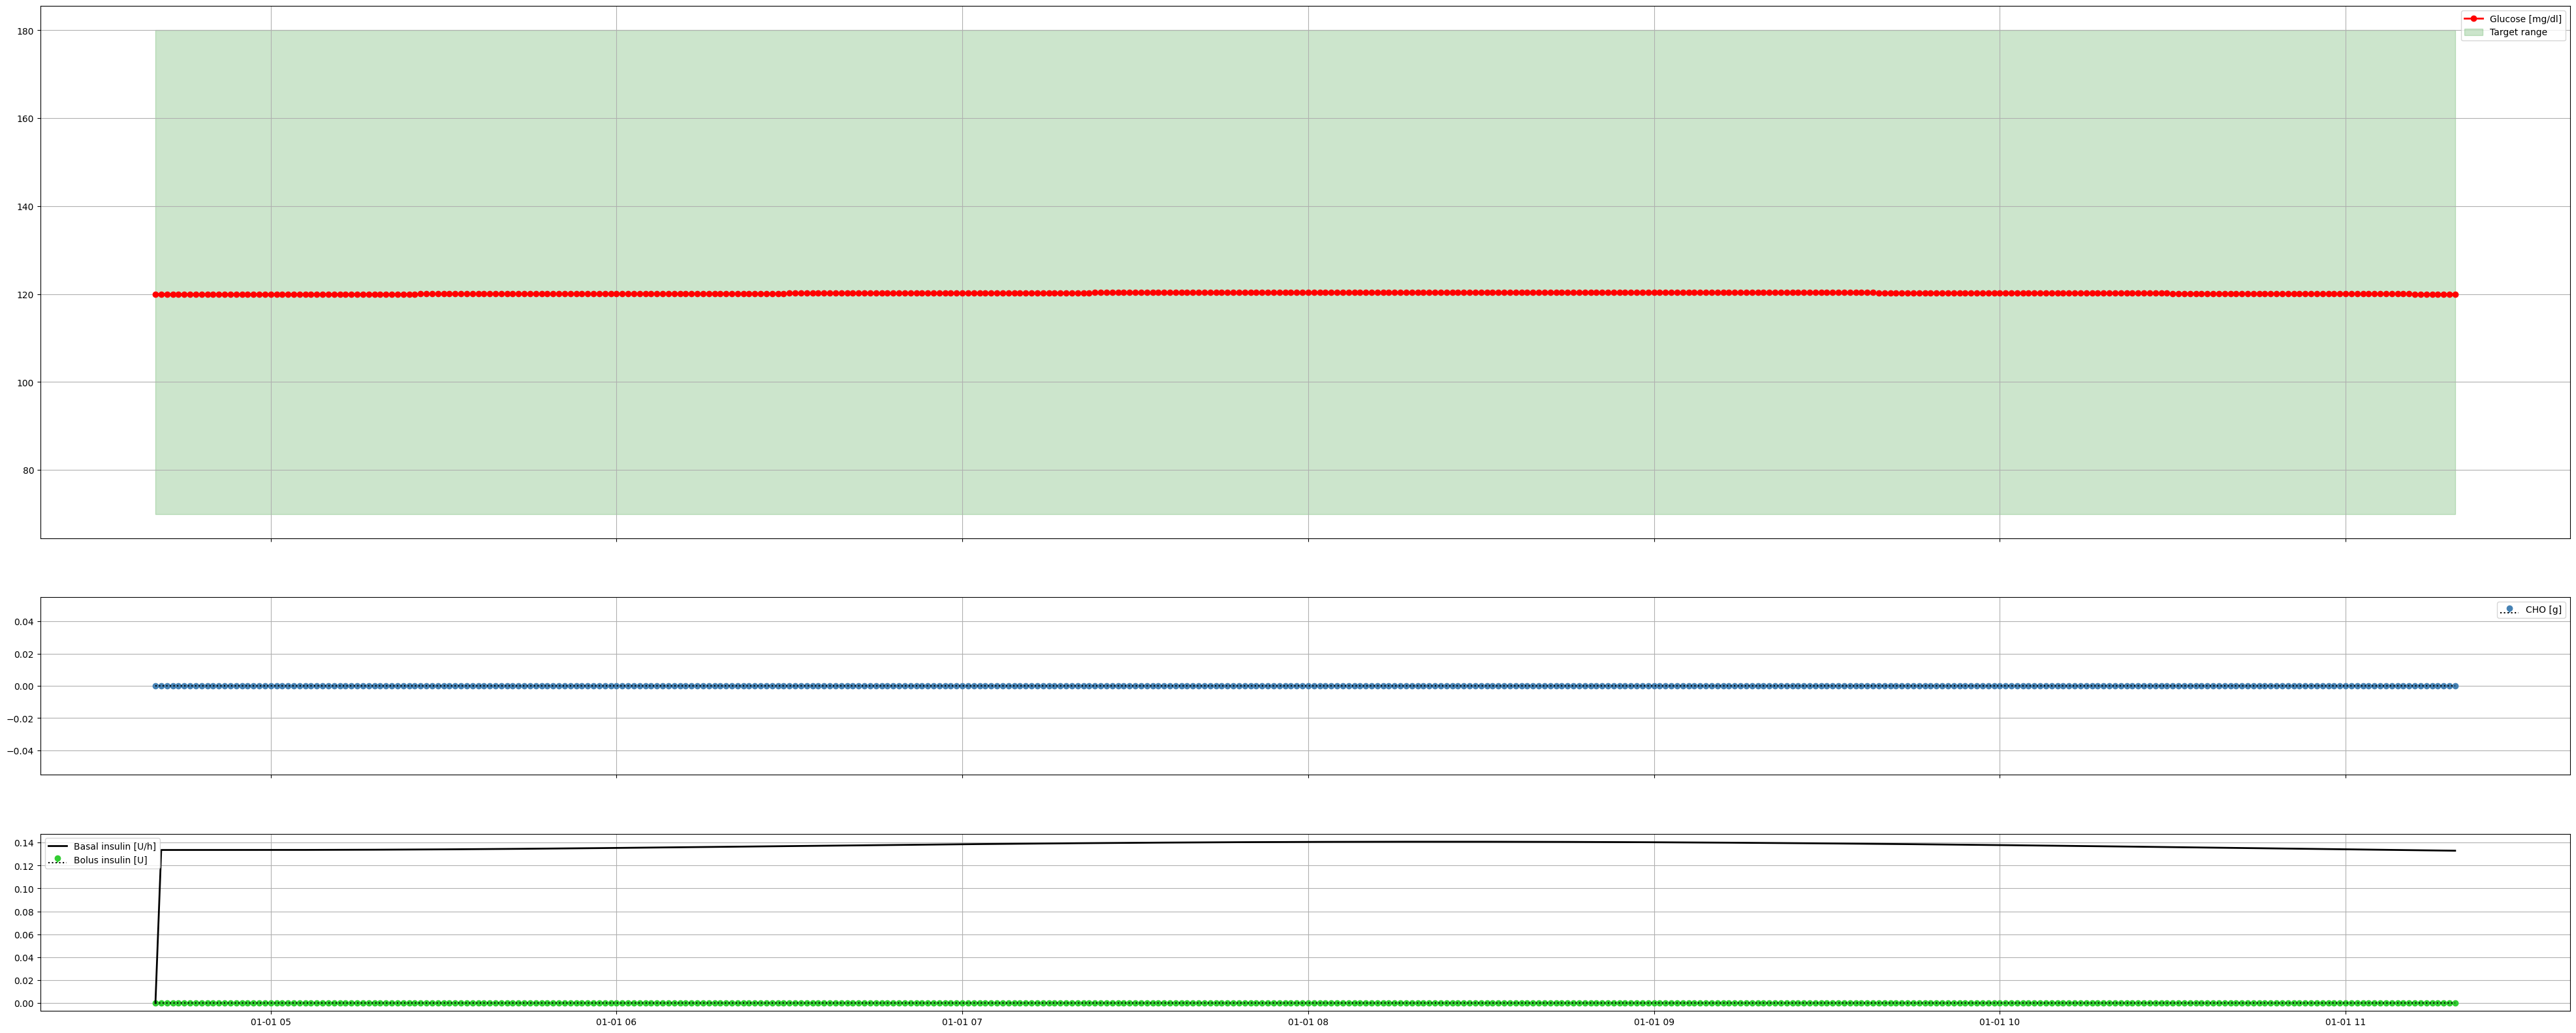

In [11]:
##################################### Failure mode of InsulinCo's PID control  ###################################
basal_handler_params = dict()
basal_handler_params['default_rate'] = 0.01

# Get test data
data_given = df

# Instatiating PID Controller
pid_controller = PIDController(Ki=0.0, Kd=0.005, Kp=0.0003)

# Running the simulation
glucose, i, insulin_bolus, m, time = simulate(basal_handler=pid_controller.compute_pid,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)

data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)

It is clear from the above plot that the soft and, more dangerously, the hard limits are being violated. This behaviour is expected as the PID is an unconstrained (*and not robust*) controller. As our task is both to ensure the safety of the patient (*in all situations*) and to respect the physical limitations of the insulin pumps, we are led to implement a (*robust*) controller that includes constraints.

(*it might be interesting to analyse the case where disturbances such as exercise or a snack are taken into account, leading to a robust formulation*)

## Task 3: Model-Based Controller

Propose and implement a Model-Based controller, assuming that you access to the (linearized) system model described above and a full state measurement.

We have the following LTI dynamics
$$\textbf{x}_{k+1} = A \textbf{x}_{k} + B\textbf{u}_{k} + h$$

and apply the following change of coordinates
$$
\begin{cases}
\tilde{x} = x - x_{ss} \\
\tilde{u} = u - u_{ss}.
\end{cases}
$$

We want to solve the following optimal control problem (OPC)
$$
\begin{array}{lll}
\min_{\tilde{\textbf{x}}, \tilde{\textbf{u}}_1} & \sum_{k=0}^{K-1} \|\tilde{\textbf{x}}_k \|^2_Q + \|\tilde{\textbf{u}}_{1,k} \|_R^2 & \\
\text{s.t.} & \tilde{\textbf{x}}_{k+1} = A \tilde{\textbf{x}}_{k} + B \tilde{\textbf{u}}_{k} + h, & k=0, \ldots, K-1 \\
& 0 - \textbf{u}_{ss} \leq \tilde{\textbf{u}}_{1,k} \leq 0.04 - \textbf{u}_{ss}, & k=0, \ldots, K - 1\\
& \tilde{\textbf{x}}_{9,k} > 70 - \textbf{x}_{9,ss}, & k=0, \ldots, K - 1\\
& \tilde{\textbf{x}}_K = 0 & &
\end{array}
$$
where 
- $\textbf{u}_k = \begin{bmatrix}i_k & m_k \end{bmatrix}^T$ from the task description,
- $\textbf{x}_{9,k} = G_{k} > 70$ mg/dl representing the hard constraint for the glucose level:
- $\tilde{\textbf{x}}_K = 0$ ensuring stability,
- $Q \in \mathbb{R}^{9\times9}$ penalyzes the states, and
- $R \in \mathbb{R}^{1\times1}$ penalyzes the controllable input $i_k$.

In [60]:
class TrackingMPC:
    def __init__(self, Q:np.ndarray, R:np.ndarray, K:int):
        self.n_x = 9
        self.m_u = 1 # only the basal insulin rate is controlled
        
        # Check if dimensions of Q are 9x9
        if Q.shape != (self.n_x, self.n_x):
            raise ValueError("Q must be a 9x9 matrix.")
        
        # Check if dimensions of R are 1x1
        if R.shape != (self.m_u, self.m_u):
            raise ValueError("R must be a 1x1 matrix.")
        
        self.Q = Q
        self.R = R
        self.K = K # TODO dovrebbe essere maggiore di tau per vedere l'effetto dell'input CIRCA 4 TAU
    
    def compute_mpc(self, model, x0, tau, time_index, inputs_, xss, uss, dss):
        """
        Implements the tracking MPC.

        Parameters
        -------
        model: the T1DModel class describing the dynamics, provided by ReplayBG
        x0: the current state
        tau: delay of the system in min
        time_index: shows the current time step
        inputs_: a time series with the basal input that was/will be applied to the system
                (useful for implementing delay)
        xss, uss: the linearization point
        dss: Contains basal_handler_params and servers two functions:
            1) a dict that for the controller hyperparameters.
            2) memory for the next iteration (hence dss also being an output)
        
        Returns
        -------
        i: The basal insulin rate to administer at time[time_index+1].
        dss: [see above]
        """
        print("------ START ------")
        # Get next K meals for the second input
        meal = model.get_discretized_meals(initial_time_step=time_index, duration=self.K, T=1)

        # Assuming meal needs to be a row with length self.K
        if meal.ndim == 1:  # Ensure meal is a 1D array
            meal = np.reshape(meal, (1, -1))  # Reshape to (1, self.K) if not already

        m = cp.Parameter(meal.shape)
        m.value = meal

        # Define variables and change of coordinates
        x = cp.Variable((self.n_x, self.K + 1))
        i = cp.Variable((self.m_u, self.K))
        x_tilde = x - xss[:, np.newaxis]
        i_tilde = i - uss

        cost = 0
        constr = []
        # for k in range(self.K):
        for k in range(0, self.K, int(tau)):
            # cost += cp.quad_form(x[8, k] - xss[8], self.Q) + cp.square(i[0, k] - uss) * self.R
            cost += cp.square(x[8, k] - xss[8]) * self.R + cp.square(i[0, k] - uss) * self.R * 0

            u_k = cp.vstack([i[0, k], m[0, k]])
            u_k = cp.reshape(u_k, (2,))

            constr += [x[:, k + 1] == A_ @ x[:, k] + B_ @ u_k + h_,
                       i[0, k] >= 0,
                       i[0, k] <= 0.04*1 - uss,]
                    #    x[8, k] >= 70,]
                    #    x[:, self.K] == xss] # TODO make the sys unfeasible
        # for k in range(self.K):
        #     u_tilde_k = cp.vstack([i_tilde[0, k], m[0, k]])
        #     u_tilde_k = cp.reshape(u_tilde_k, (2,))

        #     cost += cp.quad_form(x_tilde[:, k], self.Q) #+ cp.square(i_tilde[:, k]) @ self.R
        #     constr += [x_tilde[:, k + 1] == A_ @ x_tilde[:, k] + B_ @ u_tilde_k + h_,
        #                 i_tilde[0, k] <= 0.04 - uss,
        #                 i_tilde[0, k] >= 0 - uss,
        #                 x_tilde[8, k] >= 70 - xss[8],
        #                 x_tilde[:, self.K] == 0]
            
        # Sums problem objectives and concatenates constraints
        constr += [x[:, 0] == x0]
        problem = cp.Problem(cp.Minimize(cost), constr)
        # problem.solve(verbose = True)
        problem.solve(solver=cp.MOSEK, verbose = False) #suggested to use MOSEK solver
        print(time_index)
        # print(x.value)
        # print(i.value)

        # control_output = i_tilde[0,0].value
        control_output = i[0,0].value + uss
        # control_output = i[0,0].value
        # control_output = uss
        print(control_output)
        print("------ FINISH ------")
        return control_output, dss

------ START ------
0
0.004451784095622793
------ FINISH ------
------ START ------
1
0.004451784095622793
------ FINISH ------
------ START ------
2
0.004451784095622793
------ FINISH ------
------ START ------
3
0.004451784095622807
------ FINISH ------
------ START ------
4
0.004451784095622807
------ FINISH ------
------ START ------
5
0.004451784095622793
------ FINISH ------
------ START ------
6
0.004451784095622793
------ FINISH ------
------ START ------
7
0.004451784095622793
------ FINISH ------
------ START ------
8
0.004451784095622793
------ FINISH ------
------ START ------
9
0.004451784095622793
------ FINISH ------
------ START ------
10
0.004451784095622793
------ FINISH ------
------ START ------
11
0.004451784095622807
------ FINISH ------
------ START ------
12
0.004451784095622793
------ FINISH ------
------ START ------
13
0.004451784095622793
------ FINISH ------
------ START ------
14
0.004451784095622807
------ FINISH ------
------ START ------
15
0.0044517840

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\py_agata\variability\__init__.py:900: RuntimeWarning: Mean of empty slice
  mage_day_minus[d] = np.nanmean(excursions[excursions < 0])
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


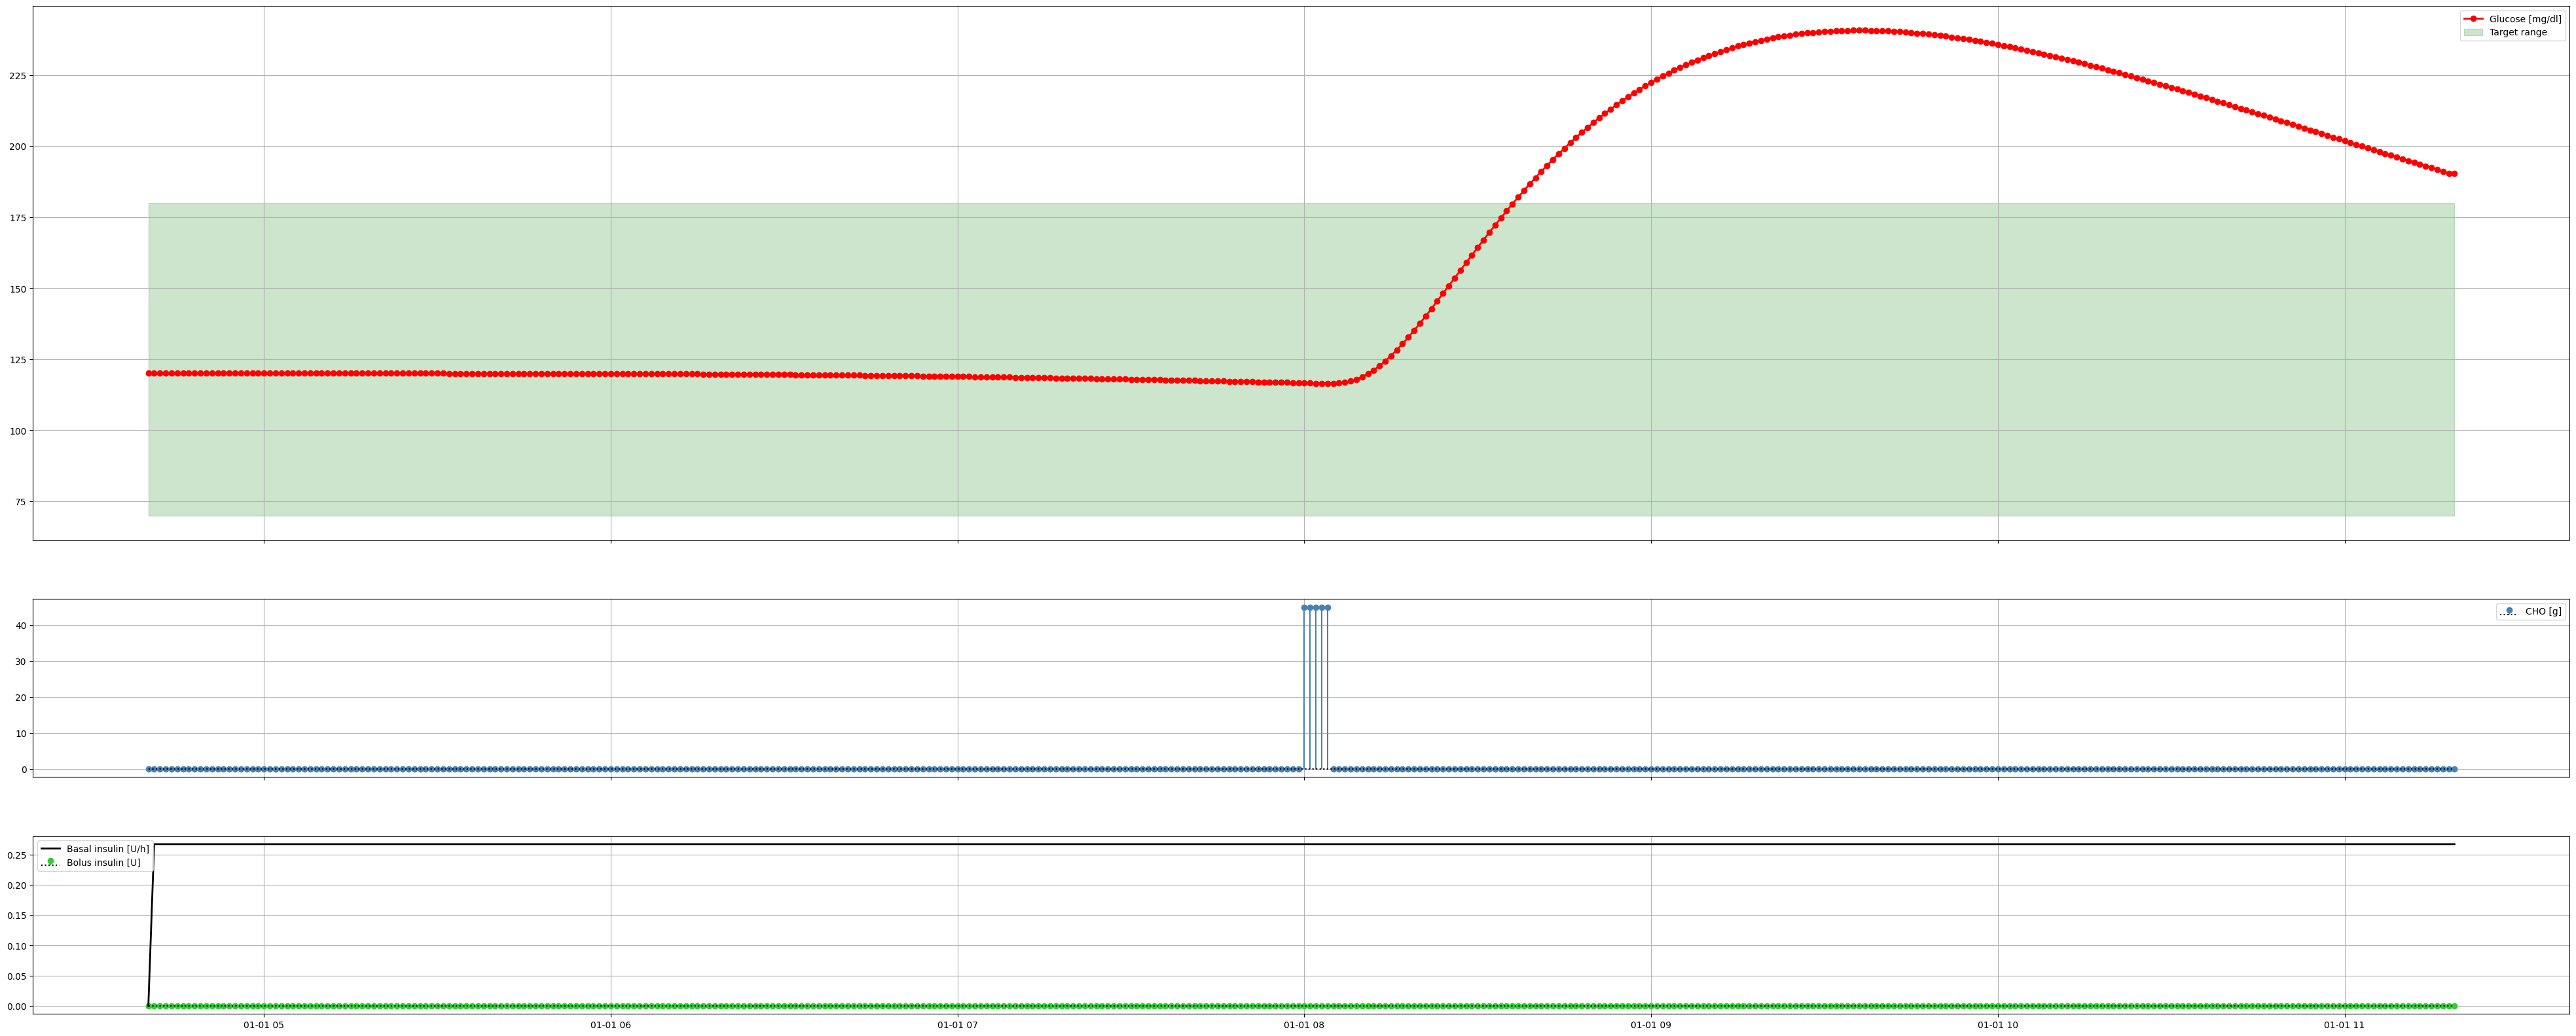

In [61]:
##################################### Tracking MPC ###################################
basal_handler_params = dict()

# Get test data
# data_given = pd.read_csv('data/task01_failure_mode.csv') # TODO fare csv per mpc e data_driven
data_given = pd.read_csv('data/easy_test.csv') # TODO fare csv per mpc e data_driven

# Instatiating tracking MPC
Q = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1]
])
R = np.eye(1) * 1
K = tau * 5
tracking_mpc = TrackingMPC(Q, R, K)

# Running the simulation
glucose, i, insulin_bolus, m, time = simulate(basal_handler=tracking_mpc.compute_mpc,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)

data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)

## Task 4: Data-enabled Predictive Control

Propose and implement a DeePC controller, assuming that you measure the glucose $g(t)$ and the “non-monomatic” or “inactive insulin” $i_{sc1}$ (in practice, $i_{sc1}$ cannot be measured. Removing this measurement is one option for the bonus). Use the data that InsulinCo has provided to you as the training data.

The file `DeePC_data.pkl` contains a pandas data frame with 4 columns:
- $m(t)$ (u[1]): Carbohydrate intake/"meals" (uncontrolled)
- $i(t)$ (u[0]): Exogenous/Basal insulin injections (controlled)
- $i_{sc1}(t)$ (x[5]): the insulin in a non-monomeric state 
-  $g(t)$ (x[8]): the interstitial glucose concentration

Every row is a different time step corresponding to 1 minute intervals.

To discretize the meals in a way that is equivalent to `get_discretized_meals`, you should add all the meals in a given interval. For example, if one uses a time-discretization of 5 minutes, the meals vector entry for the first control timestep should be m[0] = sum(meal[0:5]), and for the second control timestep m[1] = sum(meal[5:10]). For the input, you might want to use the average, i.e., i[0] = avg(input[0:5]), though that is a design decision that is up to you.

Also note that you may not need to use all the timesteps in the file.

To load the dataframe, you can use the following line:
`df = pd.read_pickle("DeePC_data.pkl")`
which loads the dataframe into the variable "df".

To solve the optimization problem, we advise you to use the MOSEK solver ('problem.solve(solver=cp.MOSEK'), though you are welcome to use other solvers.

In [62]:
# Write your code here

## Task 5: Bonus

Use the ReplayBG simulator, or data from the simulator, to either improve upon one of the two AP controllers you proposed in a significant manner, or demonstrate a new controller which requires a simulator or more data.






In [63]:
# Write your code here

## If you want to run your code on a different machine

If you choose to run the code on a different machine (e.g. your own etc.), you can do so by creating your own virtual environment. You may also find it helpful to use Mosek, which will require a [Mosek academic license](https://www.mosek.com/products/academic-licenses/).
In order to activate the environment, before opening the notebook, you need to navigate to the provided directory of the project and then source your environment. The packages are compatible with Pyhton3.11, so you should use this version in your environment. The described process will look like/similar to this:

```terminal
git clone https://gitlab.ethz.ch/project_directory.git

cd ~/ProjectDirectory

python -m venv venv 

source venv/bin/activate

pip install -r requirements.txt

pip install cvxpy

pip install mosek

pip install jupyter lab

jupyter lab
```

<font color='red'>NOTE</font>: To directly create your virtual environment using python3.11, you need to find the location of your python3.11 executable and then run `C:/path/to/your/python3-11-executable/python.exe -m venv venv` for windows or `path/to/python3.11 -m venv venv` for ubuntu.